In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skopt import gp_minimize

### Target function

In [2]:
noise_level = 0.05

def f(x, noise_level=noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2)) + np.random.randn() * noise_level

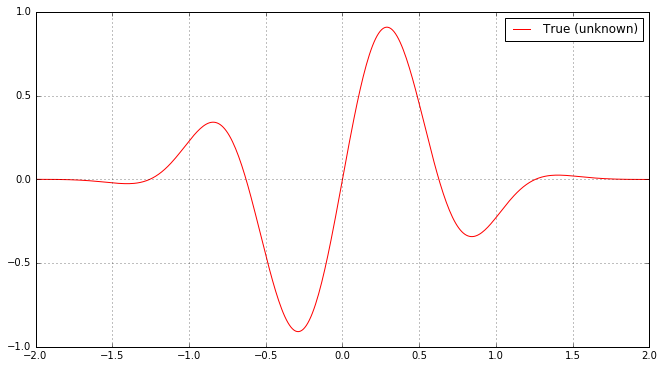

In [3]:
# Plot f(x) + contours
x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = [f(x_i, noise_level=0.0) for x_i in x]

plt.figure(figsize=(11,6))
plt.plot(x, fx, "r", label="True (unknown)")
# plt.fill(np.concatenate([x, x[::-1]]),
#          np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx], 
#                          [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
#          alpha=.2, fc="r", ec="None")
plt.legend()
plt.grid()
plt.show()

### Optimization

In [4]:
from skopt import gp_minimize

kappa= 10.1

res = gp_minimize(f,                  # the function to minimize
                  [(-2.0, 2.0)],      # the bounds on each dimension of x
                  acq_func="LCB",      # the acquisition function
                  n_calls=30,         # the number of evaluations of f 
                  n_random_starts=10,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=123, 
                  kappa=kappa, 
                  n_jobs=3)   # the random seed

In [5]:
"x^*=%.4f, f(x^*)=%.4f" % (res.x[0], res.fun)

'x^*=-0.2636, f(x^*)=-0.9667'

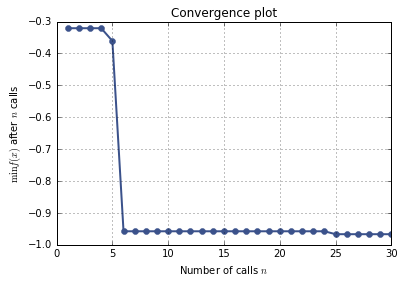

In [6]:
from skopt.plots import plot_convergence
plot_convergence(res);

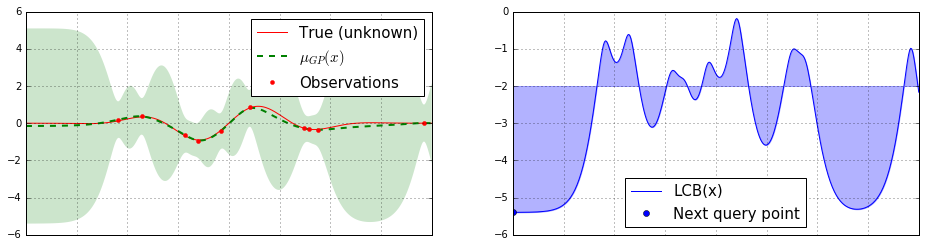

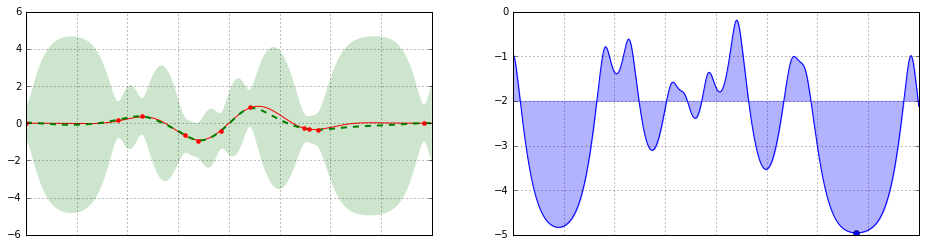

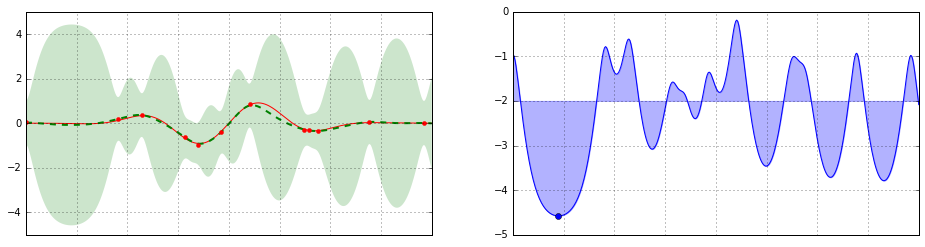

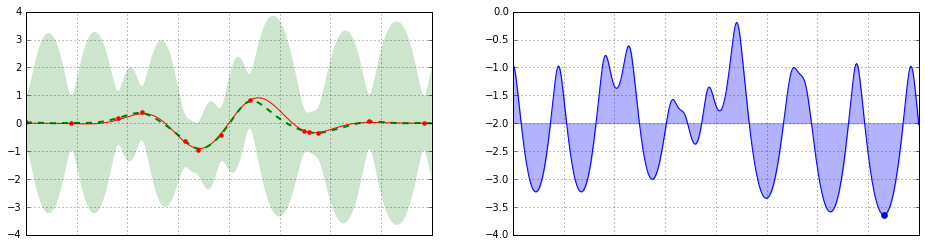

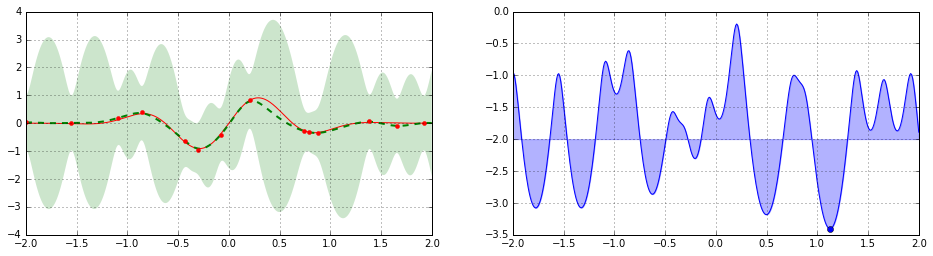

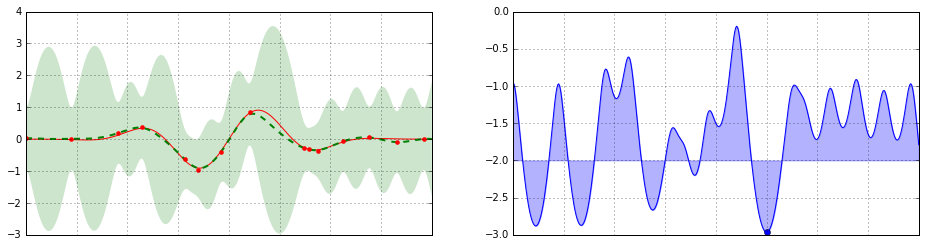

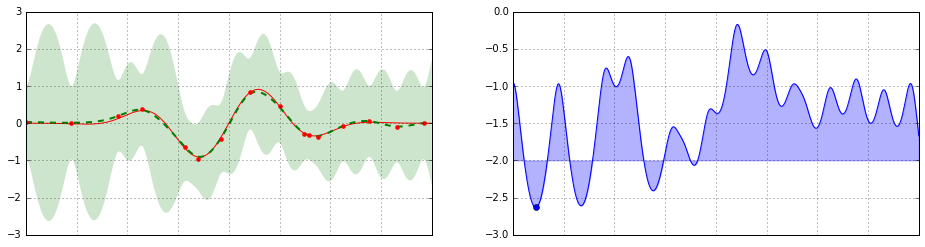

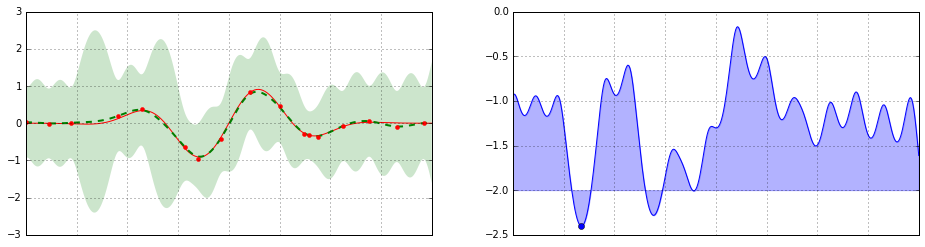

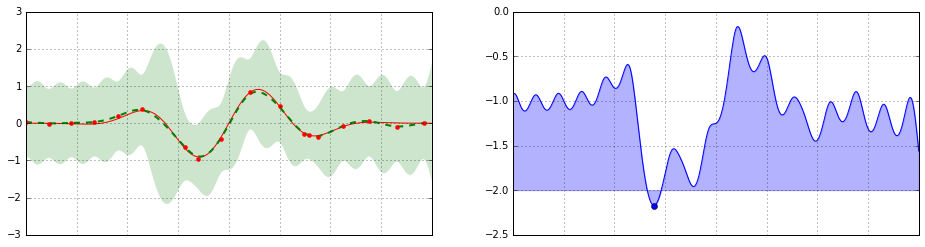

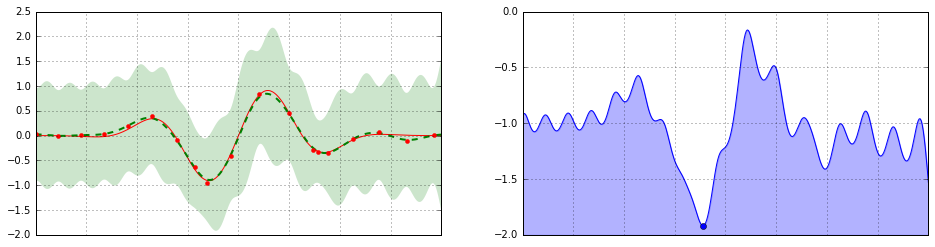

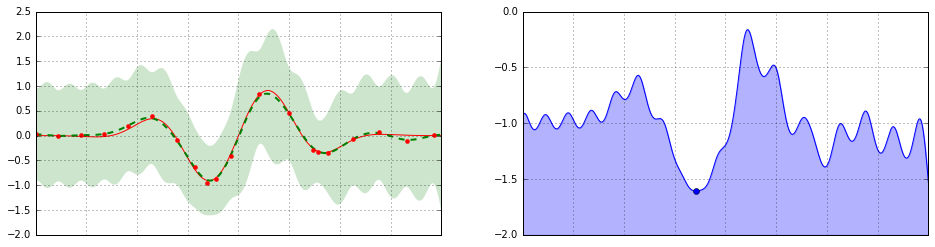

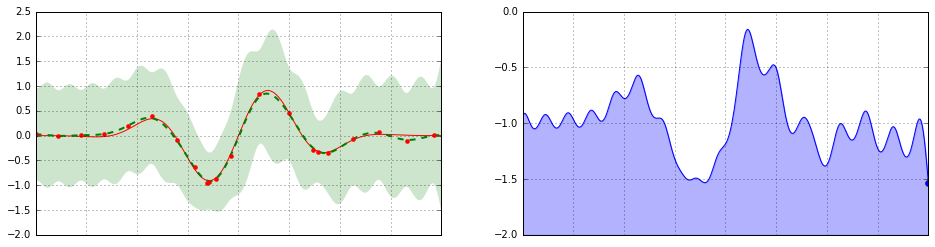

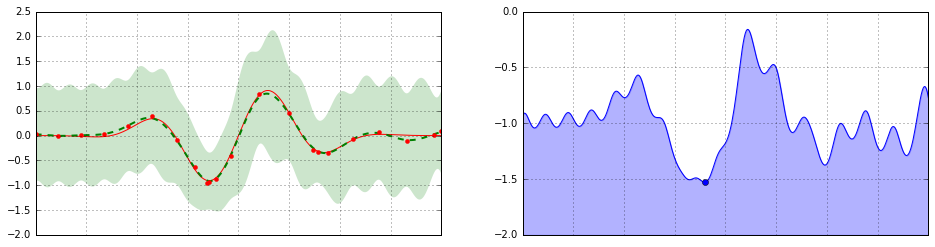

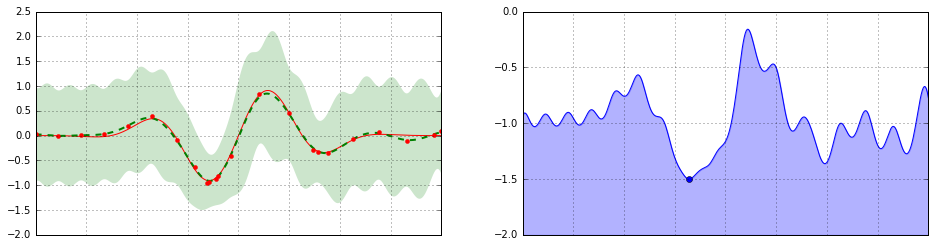

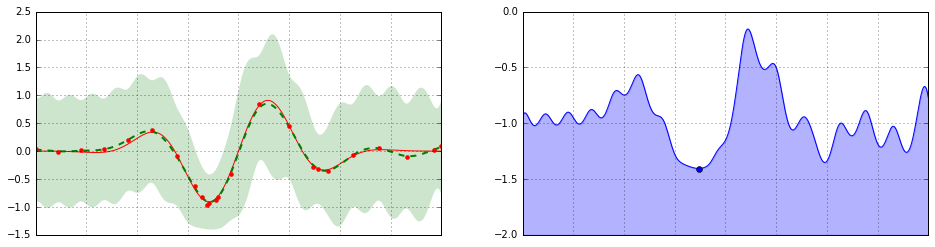

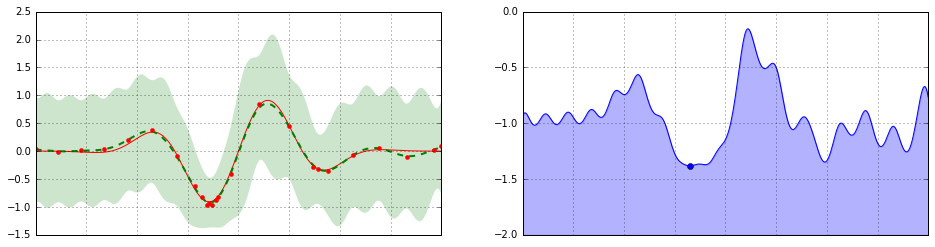

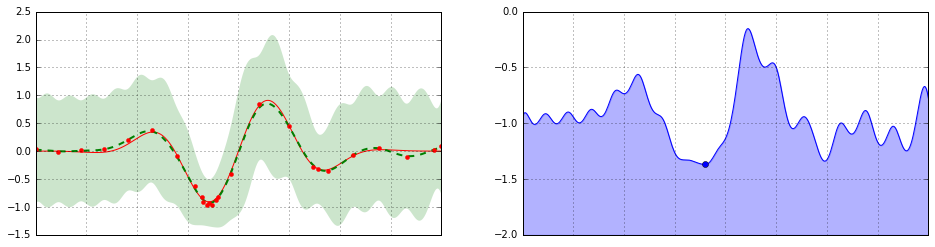

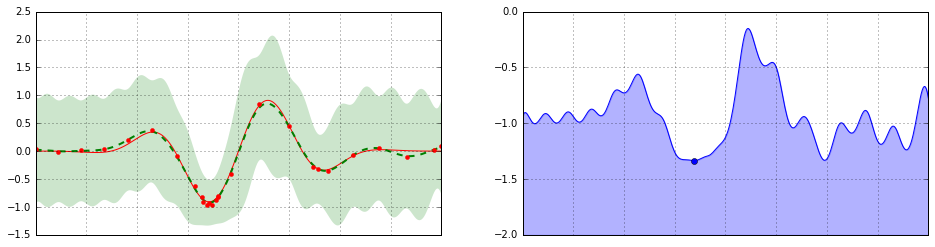

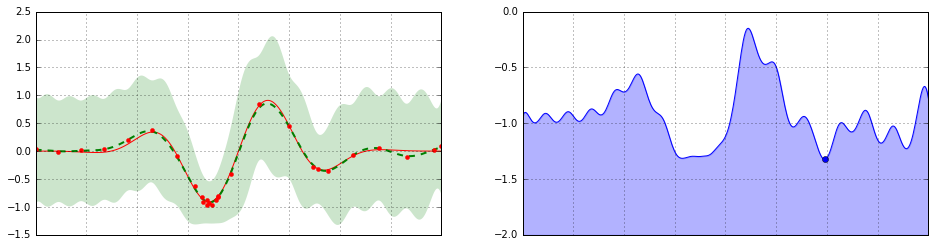

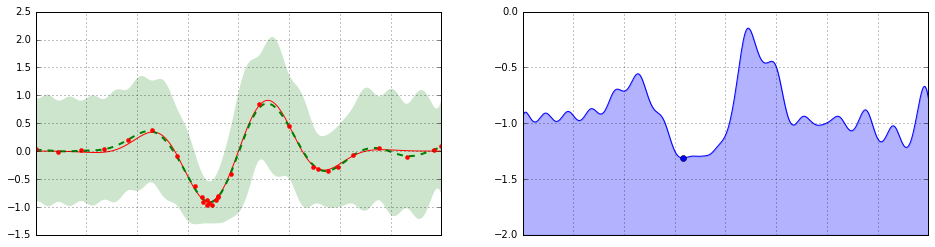

In [7]:
from skopt.acquisition import gaussian_lcb

x = np.linspace(-2, 2, 400).reshape(-1, 1)
x_gp = res.space.transform(x.tolist())
fx = np.array([f(x_i, noise_level=0.0) for x_i in x])

# Plot the 5 iterations following the 5 random points
for n_iter in range(20):
    
    plt.rcParams["figure.figsize"] = (16, 4)
    
    gp = res.models[n_iter]
    curr_x_iters = res.x_iters[:10+n_iter]
    curr_func_vals = res.func_vals[:10+n_iter]

    # Plot true function.
    plt.subplot(1, 2, 1)
    plt.plot(x, fx, "r", label="True (unknown)")
#     plt.fill(np.concatenate([x, x[::-1]]),
#              np.concatenate([fx - kappa * noise_level, 
#                              fx[::-1] + kappa * noise_level]),
#              alpha=.2, fc="r", ec="None")

    # Plot GP(x) + contours
    y_pred, sigma = gp.predict(x_gp, return_std=True)
    plt.plot(x, y_pred, "g--", label=r"$\mu_{GP}(x)$", linewidth=2)
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred - kappa * sigma, 
                             (y_pred + kappa * sigma)[::-1]]),
             alpha=.2, fc="g", ec="None")

    # Plot sampled points
    plt.plot(curr_x_iters, curr_func_vals,
             "r.", markersize=8, label="Observations")
    
    # Adjust plot layout
    plt.grid()

    if n_iter == 0:
        plt.legend(loc="best", prop={'size': 15}, numpoints=1)
        
    if n_iter != 4:
        plt.tick_params(axis='x', which='both', bottom='off', 
                        top='off', labelbottom='off') 

    # Plot LCB(x)
    plt.subplot(1, 2, 2)
    acq = gaussian_lcb(x_gp, gp, kappa=kappa)
    plt.plot(x, acq, "b", label="LCB(x)")
    plt.fill_between(x.ravel(), -2.0, acq.ravel(), alpha=0.3, color='blue')
    
    next_x = res.x_iters[10+n_iter]
    next_acq = gaussian_lcb(res.space.transform([next_x]), gp, kappa=kappa)
    plt.plot(next_x, next_acq, "bo", markersize=6, label="Next query point")
    
    # Adjust plot layout
    plt.grid()
    
    if n_iter == 0:
        plt.legend(loc="best", prop={'size': 15}, numpoints=1)
        
    if n_iter != 4:
        plt.tick_params(axis='x', which='both', bottom='off', 
                        top='off', labelbottom='off') 

    plt.show()

### Дополнительные задания:

1. Установите kappa = 0.1, 1, 10, 100. В чем разница?
2. Выберите любую двумерную функцию и найдите ее отпимум. 